# MEMBANGUN KLASIFIKASI GAMBAR 'ROCK-PAPER-SCISSORS' MENGGUNAKAN CONVOLUTIONAL NEURAL NETWORK

## Import Library yang Digunakan

In [1]:
#import library yang dibutuhkan
import numpy as np
from google.colab import files
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image

#generate image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#unzip the data
import zipfile,os

#visualize the image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
%matplotlib inline




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Download dan unzip data

In [2]:
# download data dari website
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2020-07-31 07:01:20--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  7.88MB/s    in 39s     

2020-07-31 07:01:59 (7.92 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [3]:
#unzip the data
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp') #data rockpaperscissors di unzip dan dimasukkan ke direktori tmp
zip_ref.close()
 
os.listdir('/tmp/rockpaperscissors') #untuk melihat sub-direktori rockpaperscissors

['scissors', 'rock', 'paper', 'README_rpc-cv-images.txt', 'rps-cv-images']

## Preprocessing data menggunakan Augmentasi

In [4]:
#split data to train and validation
base_dir = '/tmp/rockpaperscissors' #tentukan direktori utama

#remove readme

! rm -r /tmp/rockpaperscissors/rps-cv-images #di direktori rockpaperscissors terdapat sub direktori rps-cv-images yang isinya sama dengan data di rockpaperscissors
                                              # untuk meminimalisir terjadi error kedepannya maka rps-cv-images dihapus

#membuat augmentasi
#untuk mensplit data menjadi data train dan data test, saya akan menggunakan fungsi validation di imagegenerator
data_datagen = ImageDataGenerator(
                    rescale=1./255, #rentang data diturunkan
                    height_shift_range=0.2,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest',
                    validation_split=0.4 #untuk mensplit data , training=60 % test=40%)

train_generator = data_datagen.flow_from_directory(
        base_dir,  
        target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=32,
        class_mode='categorical', #karena jumlah class lebih dari 3
        subset='training' #menjadi data training)

validation_generator = data_datagen.flow_from_directory(
        base_dir,  
        target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=32,
        class_mode='categorical', #karena jumlah class lebih dari 3
        subset='validation' #menjadi data testing)



Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


dari data diatas, didapatkan data training sebanyak 1314 images dan data test sebanyak 874 images

## Membangun Arsitektur CNN

In [5]:
#membangun models
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',kernel_initializer='he_normal', input_shape=(150,150, 3)), #kernel_initiazer untuk menormalisasi data input
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), #dropout digunakan untuk mencegah data outliers
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax') #menggunakan softmax karena class datanya lebih dari 2
])


#compile models
model.compile(loss='categorical_crossentropy', #categorical_crossenttopy karena class data lebih dari 2
              optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0), #menggunakan RMSprop dengan learning rate 0,001
              metrics=['accuracy'])


#callbacks
#dicalbacks ini, bila dalam 2 kali epochs tidak terjadi peningkatan accuracy 
#di data validation, maka lerning rate diturunkan sejauh setengah dari learning
#sebelumnya
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', #yang dimonitor adalah akurasi validation
                                            patience=2, #2 kali epoch
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

#earlystop -> jika 10 epochs tidak terjadi perubahan, hentikan training
earlystops = EarlyStopping(patience=10)

### Summary model

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

## Melatih Data

In [7]:

#train the models
train_model = model.fit(
      train_generator,
      steps_per_epoch=25,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=50,
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2,
      callbacks=[earlystops,learning_rate_reduction] #callbacks yang digunakan 2 yaitu earlystops dan learning_rate reduction)

Epoch 1/50
25/25 - 7s - loss: 1.9160 - accuracy: 0.3625 - val_loss: 0.9452 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 2/50
25/25 - 7s - loss: 0.9330 - accuracy: 0.5888 - val_loss: 1.0839 - val_accuracy: 0.6313 - lr: 0.0010
Epoch 3/50
25/25 - 7s - loss: 0.6149 - accuracy: 0.7350 - val_loss: 0.3570 - val_accuracy: 0.8687 - lr: 0.0010
Epoch 4/50
25/25 - 7s - loss: 0.5126 - accuracy: 0.8130 - val_loss: 0.2851 - val_accuracy: 0.8938 - lr: 0.0010
Epoch 5/50
25/25 - 6s - loss: 0.3942 - accuracy: 0.8649 - val_loss: 0.3892 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 6/50
25/25 - 7s - loss: 0.4521 - accuracy: 0.8550 - val_loss: 0.2633 - val_accuracy: 0.9312 - lr: 0.0010
Epoch 7/50
25/25 - 7s - loss: 0.2967 - accuracy: 0.9013 - val_loss: 0.1865 - val_accuracy: 0.9438 - lr: 0.0010
Epoch 8/50
25/25 - 7s - loss: 0.3077 - accuracy: 0.9075 - val_loss: 0.2107 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 9/50
25/25 - 7s - loss: 0.2161 - accuracy: 0.9262 - val_loss: 0.2540 - val_accuracy: 0.9438 - lr: 0.0010
E

## Summary Hasil Latih

In [8]:
score = model.evaluate(validation_generator, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.06995771080255508
Test accuracy: 0.9828375577926636


## Visualisasi data latih

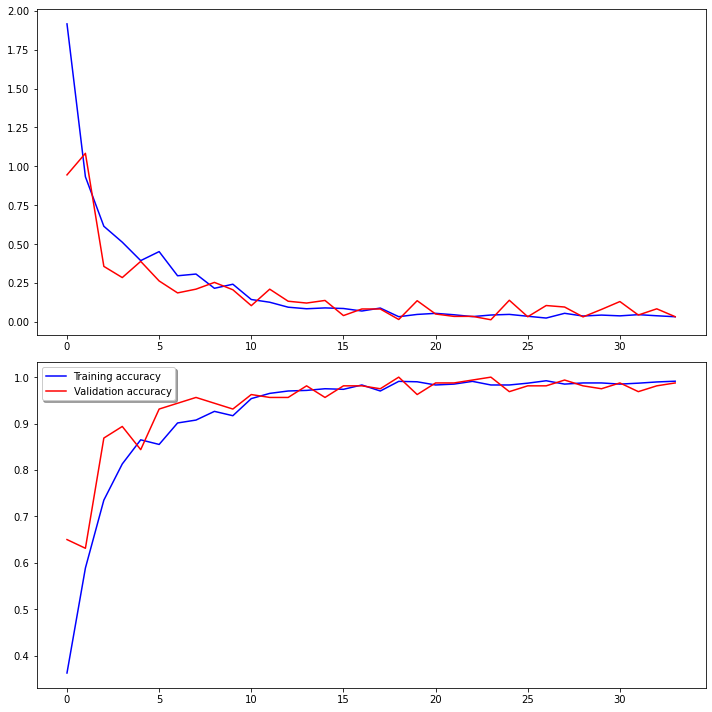

In [9]:
#visualize the training
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
ax1.plot(train_model.history['loss'], color='b', label="Training loss")
ax1.plot(train_model.history['val_loss'], color='r', label="validation loss")



ax2.plot(train_model.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(train_model.history['val_accuracy'], color='r',label="Validation accuracy")



legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Mencoba Models

Saving datasets_107582_309628_scissors_1yDUM1w2HTbuPIfO.png to datasets_107582_309628_scissors_1yDUM1w2HTbuPIfO.png
datasets_107582_309628_scissors_1yDUM1w2HTbuPIfO.png
scissors


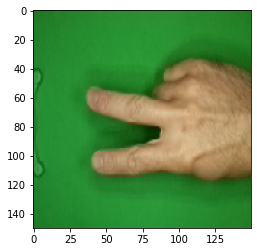

In [11]:
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  if classes[0][0]==1:
    print('paper')
  elif classes[0][1]==1:
    print('rock')
  elif classes[0][2] == 1:
    print('scissors')

Saving datasets_107582_309628_rock_1UXuUYJ4rVj2eSvt.png to datasets_107582_309628_rock_1UXuUYJ4rVj2eSvt.png
datasets_107582_309628_rock_1UXuUYJ4rVj2eSvt.png
rock


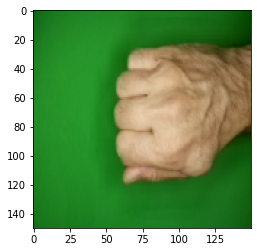

In [12]:
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  if classes[0][0]==1:
    print('paper')
  elif classes[0][1]==1:
    print('rock')
  elif classes[0][2] == 1:
    print('scissors')

Saving datasets_107582_309628_paper_04l5I8TqdzF9WDMJ.png to datasets_107582_309628_paper_04l5I8TqdzF9WDMJ.png
datasets_107582_309628_paper_04l5I8TqdzF9WDMJ.png
paper


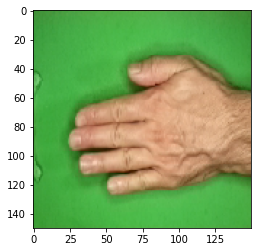

In [13]:
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  if classes[0][0]==1:
    print('paper')
  elif classes[0][1]==1:
    print('rock')
  elif classes[0][2] == 1:
    print('scissors')